In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, scipy.stats as stats, torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
from scipy.stats import spearmanr


## format data

In [2]:
# parameters
rand_seed = 42

div_pos = .0

n_positions = 20  # Number of unique positions
n_samples_per_pos = 1000  # Samples per position for better statistics


# Set random seeds for reproducibility
torch.manual_seed(rand_seed)
np.random.seed(rand_seed)

# Define stimulus positions
positions = np.linspace(-.39, .39, n_positions)

# Create expanded dataset with repetitions
X_repeats = np.tile(positions, n_samples_per_pos)  # Shape: (10000,)
Y_repeats = X_repeats.copy()  # Same values for Y
labels_expanded = (X_repeats > div_pos).astype(float)

# Stratified train/test split (80/20) - equal samples per position in each split
train_size_per_pos = int(0.8 * n_samples_per_pos)  # 400 samples per position for training
test_size_per_pos = int(0.2 * n_samples_per_pos)  # 100 samples per position for testing

train_indices = []
test_indices = []

for i, pos in enumerate(positions):
    # Get indices for this position
    pos_indices = np.where(X_repeats == pos)[0]
    
    # Randomly shuffle indices for this position
    pos_indices_shuffled = np.random.permutation(pos_indices)
    
    # Split for this position
    train_indices.extend(pos_indices_shuffled[:train_size_per_pos])
    test_indices.extend(pos_indices_shuffled[train_size_per_pos:])

# Convert to numpy arrays
train_indices = np.array(train_indices)
test_indices = np.array(test_indices)

# Split data
X_train = X_repeats[train_indices]
Y_train = Y_repeats[train_indices]
labels_train = labels_expanded[train_indices]

X_test = X_repeats[test_indices]
Y_test = Y_repeats[test_indices]
labels_test = labels_expanded[test_indices]

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float().unsqueeze(1)
Y_train_tensor = torch.from_numpy(Y_train).float().unsqueeze(1)
labels_train_tensor = torch.from_numpy(labels_train).float().unsqueeze(1)

X_test_tensor = torch.from_numpy(X_test).float().unsqueeze(1)
Y_test_tensor = torch.from_numpy(Y_test).float().unsqueeze(1)
labels_test_tensor = torch.from_numpy(labels_test).float().unsqueeze(1)

print(f"Generated {len(X_repeats)} total samples")
print(f"Training samples: {len(X_train)} ({train_size_per_pos} per position)")
print(f"Test samples: {len(X_test)} ({test_size_per_pos} per position)")
print(f"X range: [{X_repeats.min():.3f}, {X_repeats.max():.3f}]")
print(f"Unique X positions in train: {len(np.unique(X_train))}")
print(f"Unique X positions in test: {len(np.unique(X_test))}")

# Verify stratification
print("\nVerifying equal representation:")
for pos in positions[:3]:  # Check first 3 positions as example
    train_count = np.sum(X_train == pos)
    test_count = np.sum(X_test == pos)
    print(f"Position {pos:.3f}: {train_count} train, {test_count} test")

Generated 20000 total samples
Training samples: 16000 (800 per position)
Test samples: 4000 (200 per position)
X range: [-0.390, 0.390]
Unique X positions in train: 20
Unique X positions in test: 20

Verifying equal representation:
Position -0.390: 800 train, 200 test
Position -0.349: 800 train, 200 test
Position -0.308: 800 train, 200 test


## setup model

In [21]:
# Hyperparameters
divider_position = 0.0
boundary_width   = 0.05
learning_rate    = 1e-3
batch_size       = 16  # Smaller batch size for better gradient estimates
num_epochs       = 10  # Reduced epochs since we have more data
max_embedding_noise = 6
max_reward_loss = .3  # Maximum reward loss at lowest X value

epoch_test_preds = []

# Define the single head model architecture
class SingleHeadModel(nn.Module):
    def __init__(self, max_embedding_noise=0.1, boundary_position=0.0, max_reward_loss=1.0):
        super().__init__()
        # Shared layers
        self.linear1 = nn.Linear(1, 16)
        self.relu = nn.ReLU()
        
        # Single output head for regression only
        self.output_head = nn.Linear(16, 1)
        
        # Noise and reward parameters
        self.max_embedding_noise = max_embedding_noise
        self.boundary_position = boundary_position
        self.max_reward_loss = max_reward_loss
        
    def _compute_embedding_noise_magnitude(self, x):
        """
        Compute position-dependent noise magnitude.
        Max noise at boundary_position, decreases toward edges.
        """
        # Distance from boundary
        distance_from_boundary = torch.abs(x - self.boundary_position)
        
        # Use exponential decay from boundary
        max_distance = 0.39  # Your data range
        normalized_distance = distance_from_boundary / max_distance
        
        # Exponential decay: noise = max_noise * exp(-k * distance)
        k = 3.0  # Adjust this to control how quickly noise decreases
        noise_magnitude = self.max_embedding_noise * torch.exp(-k * normalized_distance)
        
        return noise_magnitude
    
    def _compute_reward_loss_magnitude(self, x):
        """
        Compute position-dependent reward loss magnitude.
        Max reward loss at lowest X value (-0.39), 0 at highest X value (0.39).
        Linear interpolation between them.
        """
        x_min = -0.39
        x_max = 0.39
        
        # Linear interpolation: reward_loss decreases linearly from x_min to x_max
        normalized_position = (x - x_min) / (x_max - x_min)  # 0 at x_min, 1 at x_max
        normalized_position = torch.clamp(normalized_position, 0, 1)  # Ensure bounds
        
        # Calculate reward loss magnitude
        # Max reward loss at x_min, 0 at x_max
        reward_loss_magnitude = self.max_reward_loss * (1 - normalized_position)
        
        return reward_loss_magnitude
        
    def forward(self, x):
        # Shared representation
        hidden = self.linear1(x)
        hidden = self.relu(hidden)
        
        # Add position-dependent noise during BOTH training and evaluation
        noise_magnitude = self._compute_embedding_noise_magnitude(x)
        # Generate random noise with position-dependent magnitude
        noise = torch.randn_like(hidden) * noise_magnitude
        hidden = hidden + noise
        
        # Single output
        output = self.output_head(hidden)
        
        return output
    
    def compute_training_loss(self, outputs, targets, inputs):
        """
        Compute training loss with MSE + position-dependent reward loss.
        """
        # Regular MSE loss
        mse_loss = (outputs - targets).pow(2).mean()
        
        # Position-dependent reward loss
        reward_loss_magnitudes = self._compute_reward_loss_magnitude(inputs)
        # Simple reward loss: penalize predictions that are too close to zero
        # You can modify this based on your specific reward structure
        reward_loss = -(reward_loss_magnitudes * outputs).mean()
        total_loss = mse_loss + reward_loss
        return total_loss, mse_loss, reward_loss

# Create single head model with noise during training and testing
model = SingleHeadModel(
    max_embedding_noise=max_embedding_noise,
    boundary_position=divider_position,
    max_reward_loss=max_reward_loss
)


# Prepare data loaders
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor, labels_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, Y_test_tensor, labels_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Optimizer & history
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
epoch_avg_performance = {
    'train_mse': [], 'train_bce': [], 'train_total': [],
    'train_class_acc': [], 'train_reg_acc': [],
    'test_mse': [], 'test_bce': [], 'test_total': [],
    'test_class_acc': [], 'test_reg_acc': []
}

## viz noise

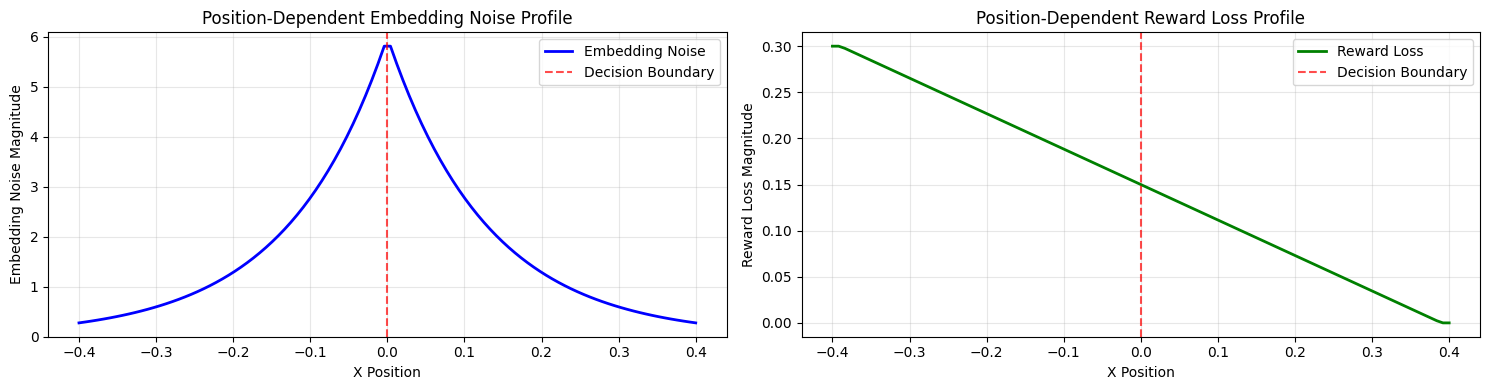

Max embedding noise at x=0: 6
Noise at x=±0.4: 0.277
Max reward loss at x=-0.39: 0.3
Reward loss at x=0.39: 0.000
Note: Embedding noise is applied during both training and testing
Note: Reward loss is only applied during training


In [22]:
# Visualize the position-dependent noise and reward loss profiles
x_test_range = torch.linspace(-0.4, 0.4, 100).unsqueeze(1)
with torch.no_grad():
    noise_magnitudes = model._compute_embedding_noise_magnitude(x_test_range)
    reward_magnitudes = model._compute_reward_loss_magnitude(x_test_range)

fig, axs = plt.subplots(1, 2, figsize=(15, 4))

# Plot 1: Embedding Noise
axs[0].plot(x_test_range.squeeze(), noise_magnitudes.squeeze(), 'b-', linewidth=2, label='Embedding Noise')
axs[0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Decision Boundary')
axs[0].set_xlabel('X Position')
axs[0].set_ylabel('Embedding Noise Magnitude')
axs[0].set_title('Position-Dependent Embedding Noise Profile')
axs[0].grid(True, alpha=0.3)
axs[0].legend()

# Plot 2: Reward Loss
axs[1].plot(x_test_range.squeeze(), reward_magnitudes.squeeze(), 'g-', linewidth=2, label='Reward Loss')
axs[1].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Decision Boundary')
axs[1].set_xlabel('X Position')
axs[1].set_ylabel('Reward Loss Magnitude')
axs[1].set_title('Position-Dependent Reward Loss Profile')
axs[1].grid(True, alpha=0.3)
axs[1].legend()

plt.tight_layout()
plt.show()

print(f"Max embedding noise at x=0: {model.max_embedding_noise}")
print(f"Noise at x=±0.4: {model._compute_embedding_noise_magnitude(torch.tensor([[0.4]])).item():.3f}")
print(f"Max reward loss at x=-0.39: {model.max_reward_loss}")
print(f"Reward loss at x=0.39: {model._compute_reward_loss_magnitude(torch.tensor([[0.39]])).item():.3f}")
print("Note: Embedding noise is applied during both training and testing")
print("Note: Reward loss is only applied during training")

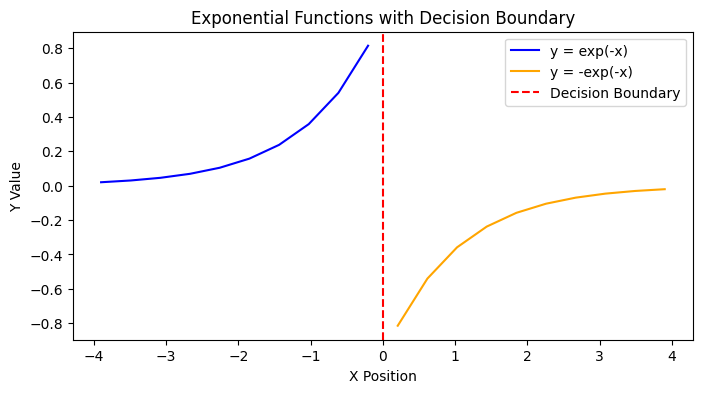

In [ ]:
# plot y = np.exp(-x) as x goes from -.39 to 0, and y = -np.exp(-x) as x goes from 0 to .39
x_plot = np.linspace(-3.9, 3.9, 20)
y_pos = np.exp(x_plot[x_plot <= 0])
y_neg = -np.exp(-x_plot[x_plot > 0])
plt.figure(figsize=(8, 4))
plt.plot(x_plot[x_plot <= 0], y_pos, label='y = exp(-x)', color='blue')
plt.plot(x_plot[x_plot > 0], y_neg, label='y = -exp(-x)', color='orange')
plt.axvline(x=0, color='red', linestyle='--', label='Decision Boundary')
plt.xlabel('X Position')
plt.ylabel('Y Value')
plt.title('Exponential Functions with Decision Boundary')
plt.legend()
plt.show()

## train-test

In [23]:
from sklearn.metrics import r2_score

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_total_loss = 0.0
    epoch_train_mse = 0.0
    epoch_train_reward = 0.0
    train_targets_all = []
    train_outputs_all = []

    for inputs, targets, class_labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)

        # Compute training loss (MSE + reward loss)
        total_loss, mse_loss, reward_loss = model.compute_training_loss(outputs, targets, inputs)
        
        total_loss.backward()
        optimizer.step()

        # Accumulate losses and predictions
        epoch_train_total_loss += total_loss.item()
        epoch_train_mse += mse_loss.item()
        epoch_train_reward += reward_loss.item()
        train_targets_all.append(targets.detach().numpy())
        train_outputs_all.append(outputs.detach().numpy())

    # Evaluation phase (only MSE loss)
    model.eval()
    epoch_test_mse = 0.0
    test_targets_all = []
    test_outputs_all = []
    
    with torch.no_grad():
        for inputs, targets, class_labels in test_loader:
            outputs = model(inputs)
            
            # Compute MSE loss only for testing
            test_loss = (outputs - targets).pow(2).mean()
            
            # Accumulate loss and predictions for R²
            epoch_test_mse += test_loss.item()
            test_targets_all.append(targets.numpy())
            test_outputs_all.append(outputs.numpy())
    
    # Calculate R² scores
    train_targets_concat = np.concatenate(train_targets_all)
    train_outputs_concat = np.concatenate(train_outputs_all)
    train_r2 = r2_score(train_targets_concat, train_outputs_concat)
    
    test_targets_concat = np.concatenate(test_targets_all)
    test_outputs_concat = np.concatenate(test_outputs_all)
    test_r2 = r2_score(test_targets_concat, test_outputs_concat)
    
    # Calculate Spearman correlations
    train_spearman_corr, _ = spearmanr(train_targets_concat, train_outputs_concat)
    test_spearman_corr, _ = spearmanr(test_targets_concat, test_outputs_concat)

    # Store in history
    epoch_avg_performance['train_spearman'] = epoch_avg_performance.get('train_spearman', [])
    epoch_avg_performance['train_spearman'].append(train_spearman_corr)

    epoch_avg_performance['test_spearman'] = epoch_avg_performance.get('test_spearman', [])
    epoch_avg_performance['test_spearman'].append(test_spearman_corr)

    # Store history (simplified)
    num_train_batches = len(train_loader)
    num_test_batches = len(test_loader)
    
    epoch_avg_performance['train_mse'].append(epoch_train_mse / num_train_batches)
    epoch_avg_performance['train_total_loss'] = epoch_avg_performance.get('train_total_loss', [])
    epoch_avg_performance['train_total_loss'].append(epoch_train_total_loss / num_train_batches)
    epoch_avg_performance['train_reward_loss'] = epoch_avg_performance.get('train_reward_loss', [])
    epoch_avg_performance['train_reward_loss'].append(epoch_train_reward / num_train_batches)
    
    epoch_avg_performance['train_r2'] = epoch_avg_performance.get('train_r2', [])
    epoch_avg_performance['train_r2'].append(train_r2)
    
    epoch_avg_performance['test_mse'].append(epoch_test_mse / num_test_batches)
    epoch_avg_performance['test_r2'] = epoch_avg_performance.get('test_r2', [])
    epoch_avg_performance['test_r2'].append(test_r2)
    
    # Store test predictions every epoch
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        epoch_test_preds.append({
            'epoch': epoch,
            'X_test': X_test.copy(),
            'Y_test': Y_test.copy(),
            'Y_pred': outputs.squeeze().numpy().copy(),
            'labels_test': labels_test.copy()
        })
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Total: {epoch_train_total_loss/num_train_batches:.4f}, "
          f"Train MSE: {epoch_train_mse/num_train_batches:.4f}, "
          f"Train Reward: {epoch_train_reward/num_train_batches:.4f}, "
          f"Test MSE: {epoch_test_mse/num_test_batches:.4f}")

print(f"Training completed. Collected {len(epoch_test_preds)} test prediction snapshots.")

Epoch 1/10: Train Total: 0.2511, Train MSE: 0.2610, Train Reward: -0.0099, Test MSE: 0.0601
Epoch 2/10: Train Total: 0.0478, Train MSE: 0.0580, Train Reward: -0.0102, Test MSE: 0.0555
Epoch 3/10: Train Total: 0.0441, Train MSE: 0.0523, Train Reward: -0.0082, Test MSE: 0.0488
Epoch 4/10: Train Total: 0.0396, Train MSE: 0.0454, Train Reward: -0.0058, Test MSE: 0.0430
Epoch 5/10: Train Total: 0.0359, Train MSE: 0.0399, Train Reward: -0.0041, Test MSE: 0.0367
Epoch 6/10: Train Total: 0.0333, Train MSE: 0.0360, Train Reward: -0.0027, Test MSE: 0.0327
Epoch 7/10: Train Total: 0.0314, Train MSE: 0.0331, Train Reward: -0.0017, Test MSE: 0.0327
Epoch 8/10: Train Total: 0.0302, Train MSE: 0.0315, Train Reward: -0.0013, Test MSE: 0.0293
Epoch 9/10: Train Total: 0.0303, Train MSE: 0.0315, Train Reward: -0.0012, Test MSE: 0.0321
Epoch 10/10: Train Total: 0.0296, Train MSE: 0.0306, Train Reward: -0.0010, Test MSE: 0.0352
Training completed. Collected 10 test prediction snapshots.


## performance

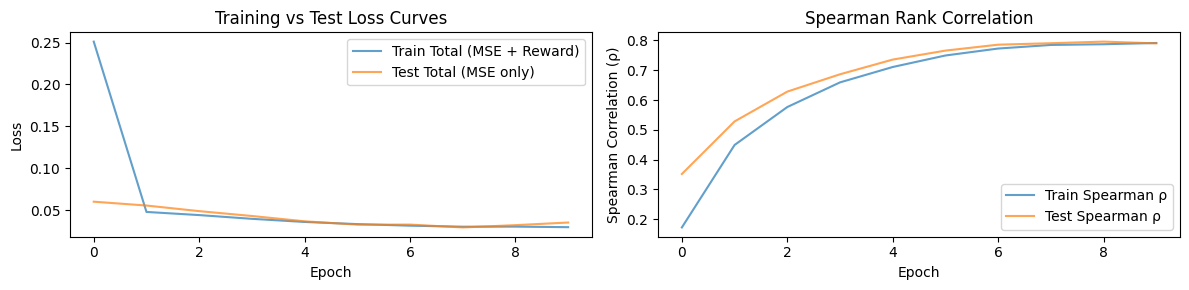

Final train total loss (MSE + Reward): 0.0296
Final train MSE: 0.0306
Final train reward loss: -0.0010
Final test MSE: 0.0352
Final train R²: 0.454
Final test R²: 0.372
Final train Spearman ρ: 0.791
Final test Spearman ρ: 0.790


In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# Plot 1: Total Loss (Train: MSE + Reward, Test: MSE only)
axs[0].plot(epoch_avg_performance['train_total_loss'], label='Train Total (MSE + Reward)', alpha=0.7)
axs[0].plot(epoch_avg_performance['test_mse'], label='Test Total (MSE only)', alpha=0.7)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training vs Test Loss Curves')
axs[0].legend()

# Plot 3: Spearman Correlation
axs[1].plot(epoch_avg_performance['train_spearman'], label='Train Spearman ρ', alpha=0.7)
axs[1].plot(epoch_avg_performance['test_spearman'], label='Test Spearman ρ', alpha=0.7)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Spearman Correlation (ρ)')
axs[1].set_title('Spearman Rank Correlation')
axs[1].legend()

plt.tight_layout()
plt.show()

# Print final performance metrics
print(f"Final train total loss (MSE + Reward): {epoch_avg_performance['train_total_loss'][-1]:.4f}")
print(f"Final train MSE: {epoch_avg_performance['train_mse'][-1]:.4f}")
print(f"Final train reward loss: {epoch_avg_performance['train_reward_loss'][-1]:.4f}")
print(f"Final test MSE: {epoch_avg_performance['test_mse'][-1]:.4f}")
print(f"Final train R²: {epoch_avg_performance['train_r2'][-1]:.3f}")
print(f"Final test R²: {epoch_avg_performance['test_r2'][-1]:.3f}")
print(f"Final train Spearman ρ: {epoch_avg_performance['train_spearman'][-1]:.3f}")
print(f"Final test Spearman ρ: {epoch_avg_performance['test_spearman'][-1]:.3f}")

## final epoch test y_hats and y_preds

In [25]:
# Create final epoch data for detailed analysis
final_snapshot = epoch_test_preds[-1]
df_final_epoch_tests = pd.DataFrame({
    'X': final_snapshot['X_test'],
    'Y_true': final_snapshot['Y_test'],
    'Y_pred': final_snapshot['Y_pred'],  # Single prediction output
    'class_true': final_snapshot['labels_test'].astype(int),
})

print(f"Final epoch data shape: {df_final_epoch_tests.shape}")
print(f"Test points: {len(df_final_epoch_tests)}")
print("\nSample of final epoch data:")
print(df_final_epoch_tests.head(10))

Final epoch data shape: (4000, 4)
Test points: 4000

Sample of final epoch data:
      X  Y_true    Y_pred  class_true
0 -0.39   -0.39 -0.074653           0
1 -0.39   -0.39 -0.065092           0
2 -0.39   -0.39 -0.058177           0
3 -0.39   -0.39 -0.065806           0
4 -0.39   -0.39 -0.072353           0
5 -0.39   -0.39 -0.095587           0
6 -0.39   -0.39 -0.080696           0
7 -0.39   -0.39 -0.059833           0
8 -0.39   -0.39 -0.092791           0
9 -0.39   -0.39 -0.071074           0


## viz behavior

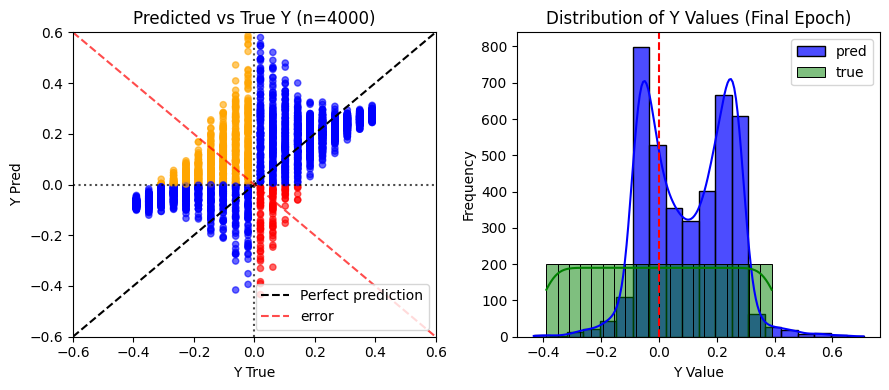

Test predictions analyzed: 4000
Sign Classification Accuracy (Y>0): 0.776
False Positive Rate: 0.195
False Negative Rate: 0.029
MSE: 0.0358
MAE: 0.1561
R² Score: 0.361


In [26]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# Create correctness categories based on REGRESSION outputs crossing 0
true_class_regression = (df_final_epoch_tests['Y_true'] > 0).astype(int)
pred_class_regression = (df_final_epoch_tests['Y_pred'] > 0).astype(int)

# Classification performance based on regression crossing 0
correct_mask = (pred_class_regression == true_class_regression)
false_positive_mask = (pred_class_regression == 1) & (true_class_regression == 0)
false_negative_mask = (pred_class_regression == 0) & (true_class_regression == 1)

# Create color array using list instead of numpy array to avoid string truncation
colors = ['blue'] * len(df_final_epoch_tests)
for i in range(len(df_final_epoch_tests)):
    if false_positive_mask[i]:
        colors[i] = 'orange'
    elif false_negative_mask[i]:
        colors[i] = 'red'

# Plot 1: y_pred vs y_true with colored scatter points
axs[0].scatter(df_final_epoch_tests['Y_true'], df_final_epoch_tests['Y_pred'], 
               c=colors, alpha=0.6, s=20)
axs[0].plot([-0.6, 0.6], [-0.6, 0.6], 'k--', label='Perfect prediction')
axs[0].plot([-0.6, 0.6], [0.6, -0.6], 'r--', alpha=0.7, label='error')
axs[0].axvline(x=0, color='black', linestyle=':', alpha=0.7)
axs[0].axhline(y=0, color='black', linestyle=':', alpha=0.7)
axs[0].set_xlabel('Y True')
axs[0].set_ylabel('Y Pred')
# xlim
axs[0].set_xlim([-0.6, 0.6])
axs[0].set_ylim([-0.6, 0.6])
axs[0].set_title(f'Predicted vs True Y (n={len(df_final_epoch_tests)})')
axs[0].legend()

# Plot 2: Distribution comparison with new colors
sns.histplot(df_final_epoch_tests['Y_pred'], bins=20, kde=True, color='blue', 
             label='pred', ax=axs[1], alpha=0.7)
sns.histplot(df_final_epoch_tests['Y_true'], bins=20, kde=True, color='green', 
             label='true', ax=axs[1], alpha=0.5)
axs[1].axvline(x=0, color='red', linestyle='--')
axs[1].set_xlabel('Y Value')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Y Values (Final Epoch)')
axs[1].legend()

plt.tight_layout()
plt.show()

# Print comprehensive statistics
print(f"Test predictions analyzed: {len(df_final_epoch_tests)}")
print(f"Sign Classification Accuracy (Y>0): {correct_mask.mean():.3f}")
print(f"False Positive Rate: {false_positive_mask.mean():.3f}")
print(f"False Negative Rate: {false_negative_mask.mean():.3f}")
print(f"MSE: {((df_final_epoch_tests['Y_pred'] - df_final_epoch_tests['Y_true'])**2).mean():.4f}")
print(f"MAE: {abs(df_final_epoch_tests['Y_pred'] - df_final_epoch_tests['Y_true']).mean():.4f}")

r2 = r2_score(df_final_epoch_tests['Y_true'], df_final_epoch_tests['Y_pred'])
print(f"R² Score: {r2:.3f}")

## viz embeddings

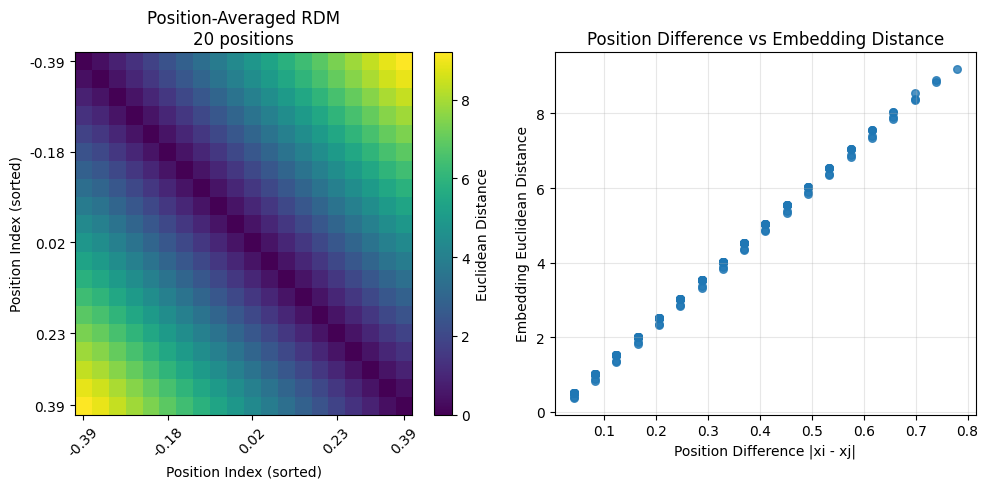

Unique positions analyzed: 20
Position-averaged embedding shape: (20, 16)
RDM shape: (20, 20)
Position range: [-0.390, 0.390]
Position difference range: [0.041, 0.780]
Embedding distance range: [0.367, 9.203]
Correlation between position and embedding distances: 1.000

Samples per position: 200
Boundary positions (around x=0):
  Position -0.062 (index 8)
  Position -0.021 (index 9)
  Position 0.021 (index 10)
  Position 0.062 (index 11)


In [9]:
# Extract embeddings from the hidden layer
def get_embeddings(model, x_vals):
    """Extract hidden layer representations (embeddings) from the model."""
    model.eval()
    embeddings = []
    
    with torch.no_grad():
        for x in x_vals:
            x_tensor = torch.tensor([[x]], dtype=torch.float32)
            
            # Get output from first layer
            hidden = model.linear1(x_tensor)  # First linear layer
            hidden = model.relu(hidden)       # ReLU activation
            
            embeddings.append(hidden.squeeze().numpy())
    
    return np.array(embeddings)

# Get average embeddings per position
unique_positions = np.unique(X_test)  # 20 unique positions
position_avg_embeddings = []

for pos in unique_positions:
    # Get all test samples for this position
    pos_mask = X_test == pos
    pos_samples = X_test[pos_mask]
    
    # Get embeddings for all samples at this position
    pos_embeddings = get_embeddings(model, pos_samples)
    
    # Average across all samples at this position
    avg_embedding = np.mean(pos_embeddings, axis=0)
    position_avg_embeddings.append(avg_embedding)

position_avg_embeddings = np.array(position_avg_embeddings)

# Compute pairwise Euclidean distances (RDM) on position averages
from scipy.spatial.distance import pdist, squareform
distances = pdist(position_avg_embeddings, metric='euclidean')
rdm = squareform(distances)

# Compute input differences for scatter plot (between positions)
input_diffs = []
embed_dists = []
for i in range(len(unique_positions)):
    for j in range(i+1, len(unique_positions)):
        input_diffs.append(abs(unique_positions[i] - unique_positions[j]))
        embed_dists.append(rdm[i, j])

# Plot the RDM and additional analysis
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# RDM heatmap
im = axs[0].imshow(rdm, cmap='viridis', aspect='auto')
axs[0].set_title(f'Position-Averaged RDM\n{len(unique_positions)} positions')
axs[0].set_xlabel('Position Index (sorted)')
axs[0].set_ylabel('Position Index (sorted)')

# Add position labels on axes - include the last position
tick_positions = np.arange(0, len(unique_positions), 5)  # [0, 5, 10, 15]
if tick_positions[-1] != len(unique_positions) - 1:  # Add last position if not included
    tick_positions = np.append(tick_positions, len(unique_positions) - 1)

tick_labels = [f'{unique_positions[i]:.2f}' for i in tick_positions]
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(tick_labels, rotation=45)
axs[0].set_yticks(tick_positions)
axs[0].set_yticklabels(tick_labels)

fig.colorbar(im, ax=axs[0], label='Euclidean Distance')

# Plot input difference vs embedding distance
axs[1].scatter(input_diffs, embed_dists, alpha=0.8, s=30)
axs[1].set_xlabel('Position Difference |xi - xj|')
axs[1].set_ylabel('Embedding Euclidean Distance')
axs[1].set_title('Position Difference vs Embedding Distance')
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Unique positions analyzed: {len(unique_positions)}")
print(f"Position-averaged embedding shape: {position_avg_embeddings.shape}")
print(f"RDM shape: {rdm.shape}")
print(f"Position range: [{unique_positions.min():.3f}, {unique_positions.max():.3f}]")
print(f"Position difference range: [{min(input_diffs):.3f}, {max(input_diffs):.3f}]")
print(f"Embedding distance range: [{min(embed_dists):.3f}, {max(embed_dists):.3f}]")

# Additional analysis: correlation between position and embedding distances
correlation = np.corrcoef(input_diffs, embed_dists)[0, 1]
print(f"Correlation between position and embedding distances: {correlation:.3f}")

# Show some specific comparisons
print(f"\nSamples per position: {np.sum(X_test == unique_positions[0])}")
print(f"Boundary positions (around x=0):")
boundary_indices = np.where(np.abs(unique_positions) < 0.1)[0]
for idx in boundary_indices:
    print(f"  Position {unique_positions[idx]:.3f} (index {idx})")